# Project - Windspeed Analysis

Author: Céaman Collins

In this notebook I will be investigating the wind speed recordings from Mace Head Atmospheric Research Station, Carna, County Galway.

![Mace Head](images/Location-of-the-Mace-Head-research-station-on-the-west-coast-of-Ireland.png)

## Importing Packages

The first step as with most projects is to import the packages that will be used in the investigation.

In [1]:
from math import sqrt
import datetime as dt
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

## Importing Data

The next step is to import the data. 

In [2]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/hly275.csv'
mace_head = pd.read_csv(url, parse_dates=['date'], index_col='date', skiprows=17, low_memory=False, date_format='%d-%b-%Y %H:%M')

Let's have a look at our data frame.

In [3]:
mace_head.head()

ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
date                                                                         
2003-08-13 01:00:00   -1           4           4                             
2003-08-13 02:00:00   -1           4           4                             
2003-08-13 03:00:00   -1           4           4                             
2003-08-13 04:00:00   -1           4           4                             
2003-08-13 05:00:00   -1           4           4                             

                     ind.3 wdsp  ind.4 wddir  
date                                          
2003-08-13 01:00:00      7           7        
2003-08-13 02:00:00      7           7        
2003-08-13 03:00:00      7           7        
2003-08-13 04:00:00      7           7        
2003-08-13 05:00:00      7           7

## Cleaning the Data

There seem to be some empty values in the data set. We can replace these space characters with `NaN` objects.

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
mace_head.replace(to_replace=' ', value=np.nan, inplace=True)

Let's have another look.

In [5]:
wind_speed = mace_head.loc[:, ['wdsp']]
wind_speed.isna().sum()


wdsp    1296
dtype: int64

We can now drop any rows that are missing values.

In [6]:
wind_speed.dropna(inplace=True)
wind_speed.head()

wdsp
date                    
2003-08-14 01:00:00    6
2003-08-14 02:00:00    4
2003-08-14 03:00:00    3
2003-08-14 04:00:00    5
2003-08-14 05:00:00    6

We can now change the data type of the whole column to `int64`. This will help with performing calculations later.

In [7]:
wind_speed['wdsp'] = pd.to_numeric(wind_speed['wdsp'])
wind_speed.head()

wdsp
date                     
2003-08-14 01:00:00     6
2003-08-14 02:00:00     4
2003-08-14 03:00:00     3
2003-08-14 04:00:00     5
2003-08-14 05:00:00     6

## Calculating monthly mean wind speed

We can get the monthly average wind speed by resampling the data.

In [8]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
wind_speed_monthly_average = wind_speed['wdsp'].resample('MS').mean()
wind_speed_monthly_average.tail()

date
2025-08-01    13.763441
2025-09-01    17.184722
2025-10-01    17.491935
2025-11-01    15.705556
2025-12-01    19.000000
Freq: MS, Name: wdsp, dtype: float64

### Generating Graphs

One of the most informative plots is a box plot - showing median, quartile ranges and even outliers.

The following documentation helped me to annotate the plot:

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch

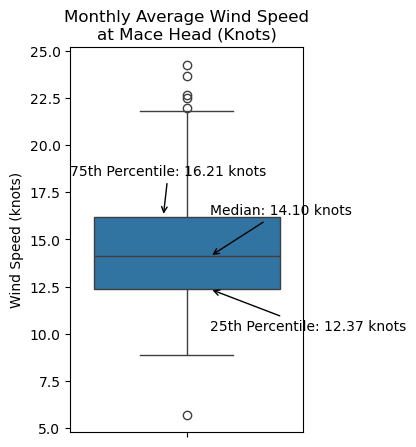

In [9]:
fig, ax = plt.subplots(figsize=(3,5))
boxplot = sns.boxplot(data=wind_speed_monthly_average, ax=ax)
plt.title('Monthly Average Wind Speed\nat Mace Head (Knots)')
plt.ylabel('Wind Speed (knots)')

plt.annotate(f'Median: {wind_speed_monthly_average.median():.2f} knots', 
             xy=(0.1, wind_speed_monthly_average.median()), 
             xytext=(0.1, wind_speed_monthly_average.median()+2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'))
percentile_25 = wind_speed_monthly_average.quantile(0.25)
plt.annotate(f'25th Percentile: {percentile_25:.2f} knots', 
             xy=(0.1, percentile_25),
             xytext=(0.1, percentile_25-2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'))
percentile_75 = wind_speed_monthly_average.quantile(0.75)
plt.annotate(f'75th Percentile: {percentile_75:.2f} knots', 
             xy=(-0.1, percentile_75),
             xytext=(-0.5, percentile_75+2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'))

plt.show()

We can also look at it on a line plot.

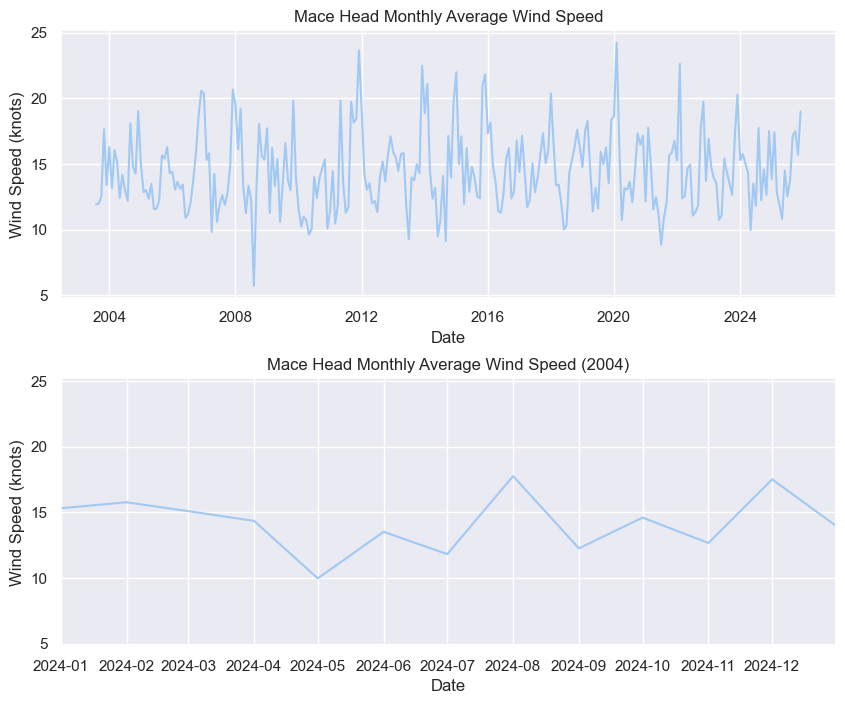

In [10]:
sns.set_theme('notebook', palette='pastel')
_, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
lineplot = sns.lineplot(data=wind_speed_monthly_average, ax=axes[0])
lineplot.set_title('Mace Head Monthly Average Wind Speed')
lineplot.set_xlabel('Date')
lineplot.set_ylabel('Wind Speed (knots)')
zoom = sns.lineplot(data=wind_speed_monthly_average, ax=axes[1])
zoom.set_title('Mace Head Monthly Average Wind Speed (2004)')
zoom.set_xlabel('Date')
zoom.set_ylabel('Wind Speed (knots)')
zoom.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 12, 31))
plt.show()
plt.close()

We can use relplot to plot the monthly average wind speeds on top of each other and colour them by year to get a better view of the seasonal highs and lows over a year.

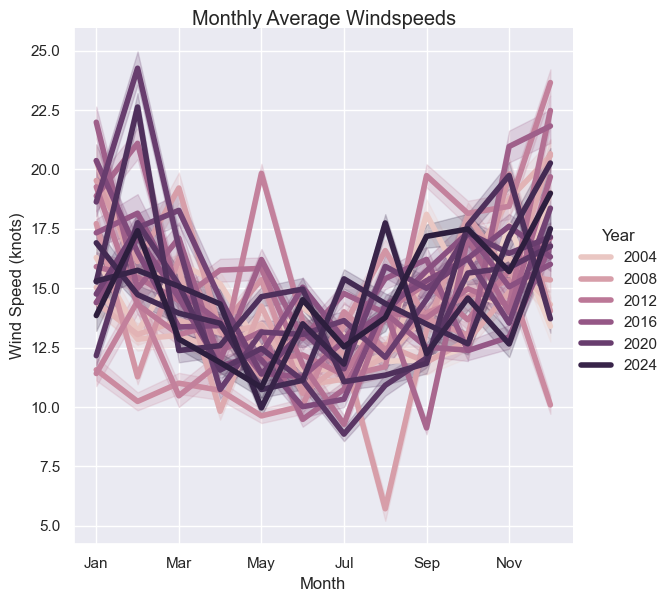

In [11]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

rel = sns.relplot(data=wind_speed, x=wind_speed.index.month, y='wdsp',
                  kind='line', height=6, aspect=1, 
                  hue=wind_speed.index.year, linewidth=4)
rel.figure.suptitle('Monthly Average Windspeeds', y=1)
rel.set_xlabels('Month')
rel.set_ylabels('Wind Speed (knots)')
rel.set(xticks=list(months.keys())[::2],
        xticklabels=list(months.values())[::2])
rel.legend.set_title('Year')
plt.show()
plt.close()

There seems to be a definite seasonal curve to the wind speeds.

We can also view the years individually, with the other years plotted behind them for context.

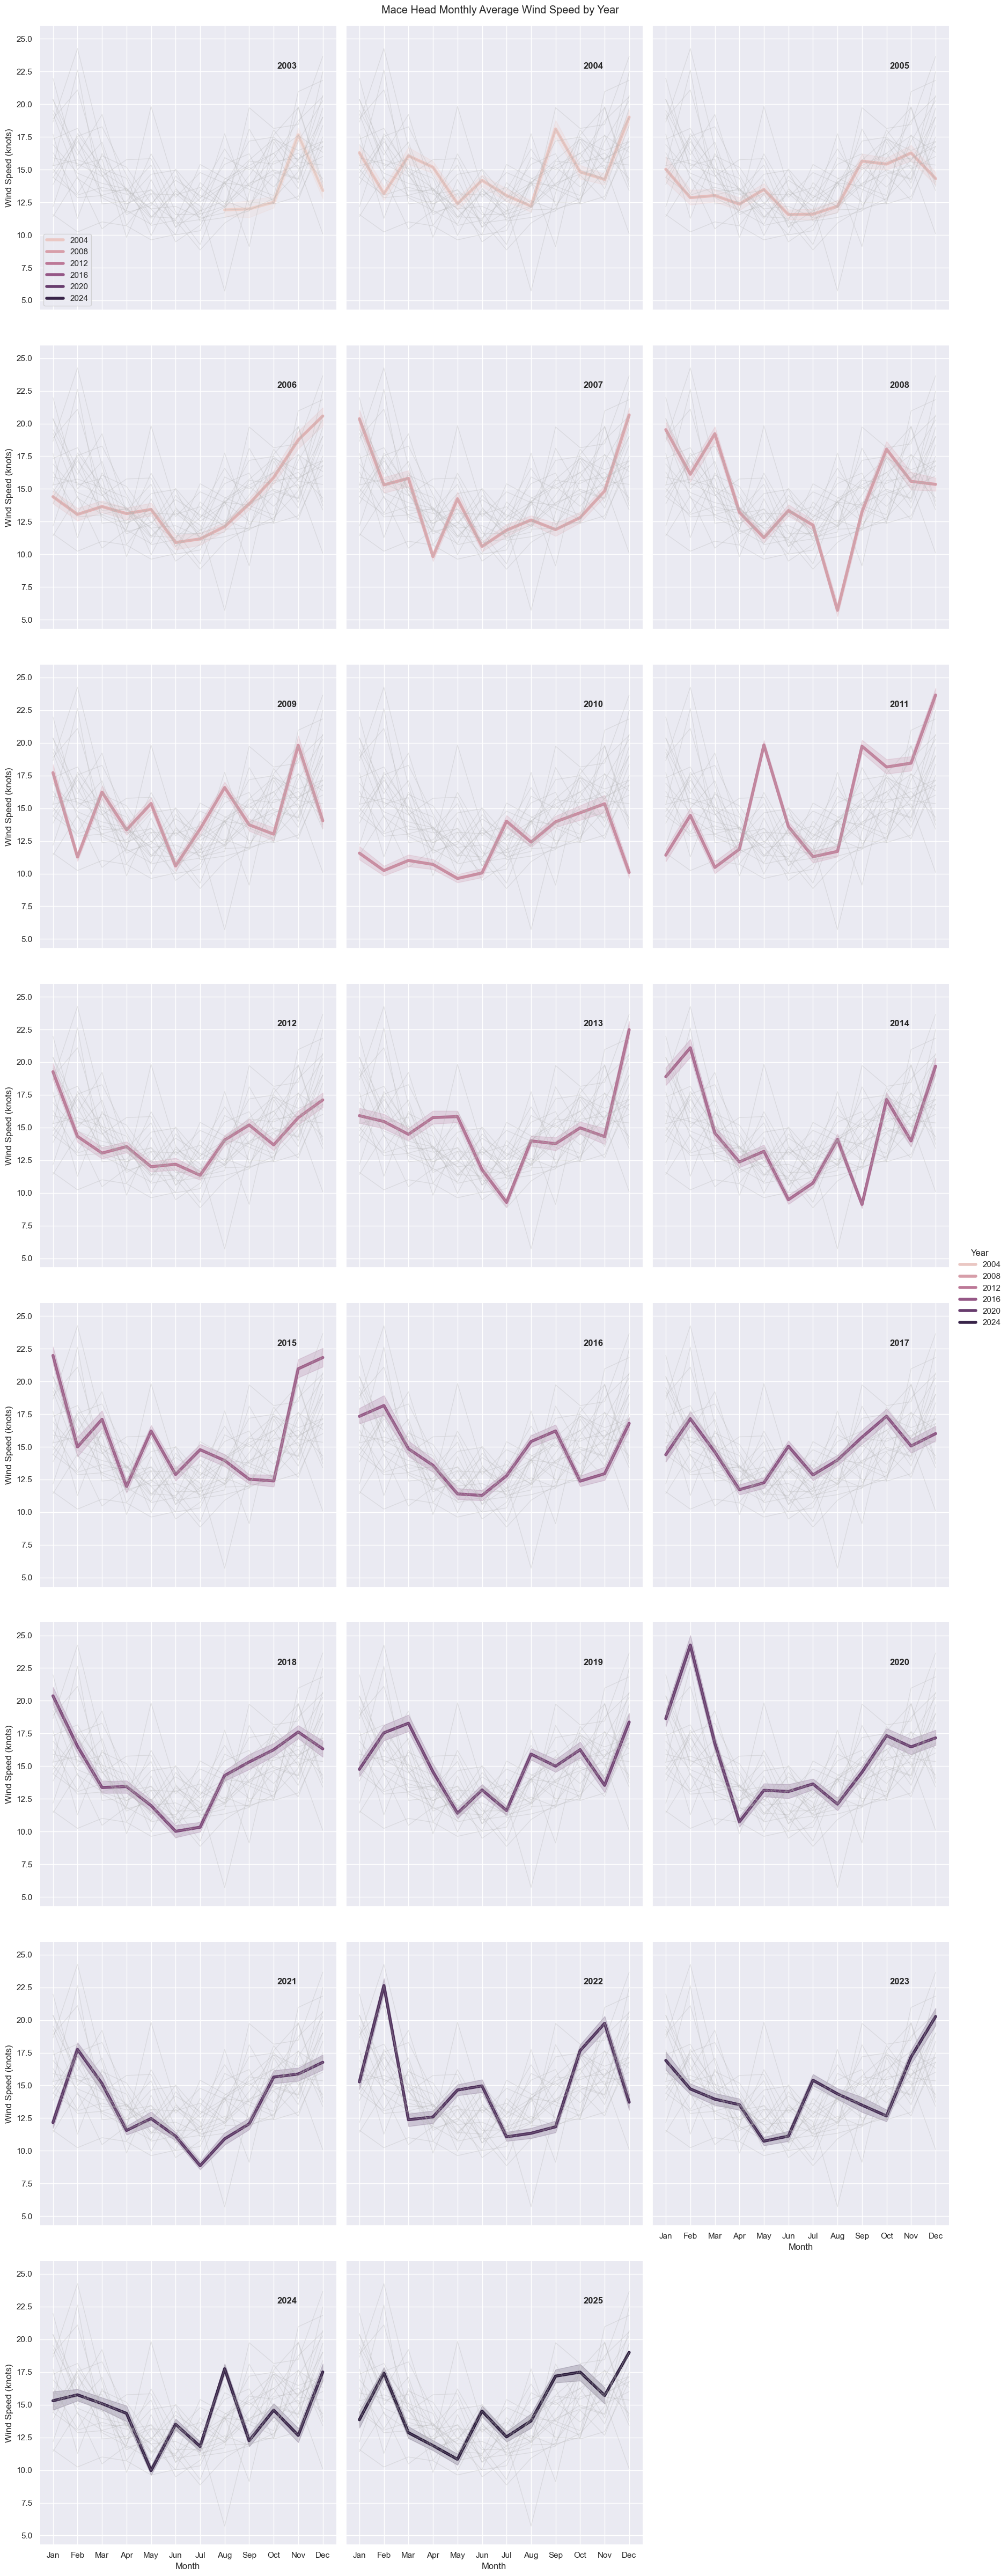

In [12]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

rel = sns.relplot(data=wind_speed, x=wind_speed.index.month, y='wdsp', kind='line',
                   height=6, aspect=1, hue=wind_speed.index.year, 
                   col=wind_speed.index.year, col_wrap=3, linewidth=4)
rel.set_axis_labels('Month', 'Wind Speed (knots)')
rel.set(xticks=list(months.keys()), xticklabels=list(months.values()))
rel.figure.suptitle('Mace Head Monthly Average Wind Speed by Year', y=1)
rel.legend.set_title('Year')

for year, ax in rel.axes_dict.items():
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")
    ax.title.set_text('')

    sns.lineplot(
        data=pd.DataFrame(wind_speed_monthly_average), 
        x=wind_speed_monthly_average.index.month, y='wdsp', 
        units=wind_speed_monthly_average.index.year,
        estimator=None, color=".7", linewidth=1, ax=ax, alpha=0.3
    )


It is incredible to see there is so much data in this dataset. We can now see which years had irregularly high or low wind speeds in context. Some years show the recognisable curve we identified in the previous figure, but some jitter unexpectedly.

## Machine Learning

In this section I will set about creating a model of my data using ARIMA machine learning models. This will take periodicity into account to give us the general model of average wind speeds by month.

I use several guides for this section. They can be found here:

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.geeksforgeeks.org/data-science/model-selection-for-arima/

https://www.datacamp.com/tutorial/arima

### Investigation

The first investigation we can perform is whether or not differencing is required for this dataset.

In [13]:
result = adfuller(wind_speed_monthly_average)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -4.146203
p-value: 0.000812
Series is stationary; no differencing needed.


C:\Users\luxxx\AppData\Local\Temp\ipykernel_50452\2223406745.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)


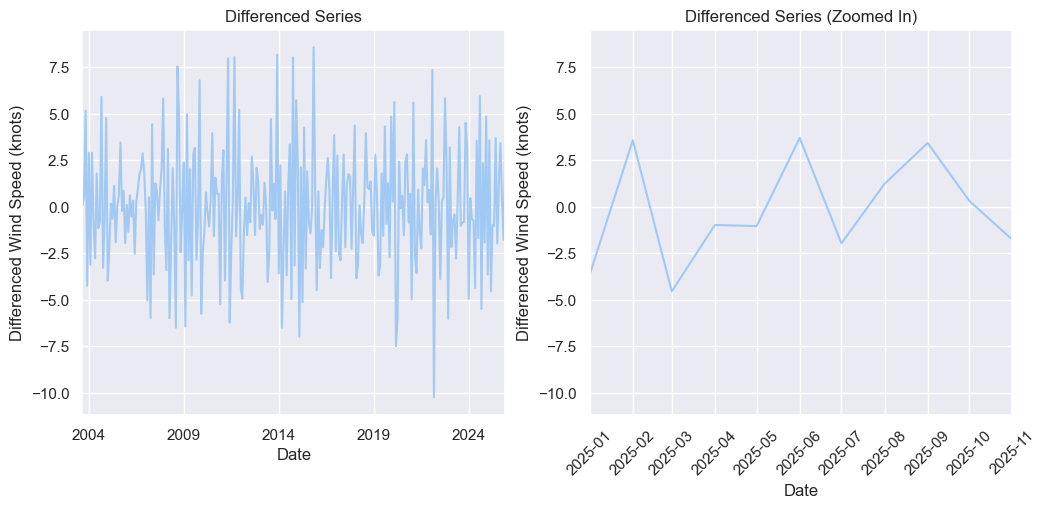

ADF Statistic (differenced): -10.666479
p-value (differenced): 0.000000


In [14]:
ts_diff = wind_speed_monthly_average.diff().dropna()

fig, axes = plt.subplots(1,2, figsize=(12,5))
ts_diff.plot(title='Differenced Series', ax=axes[0], ylabel='Differenced Wind Speed (knots)', xlabel='Date')
line = sns.lineplot(x=ts_diff.index, y=ts_diff.values, ax=axes[1])
axes[1].set_xlim(dt.datetime(2025, 1, 1), dt.datetime(2025, 11, 1))
axes[1].set(title='Differenced Series (Zoomed In)', ylabel='Differenced Wind Speed (knots)', xlabel='Date')
axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)
plt.show()

result_diff = adfuller(ts_diff)
print('ADF Statistic (differenced): %f' % result_diff[0])
print('p-value (differenced): %f' % result_diff[1])

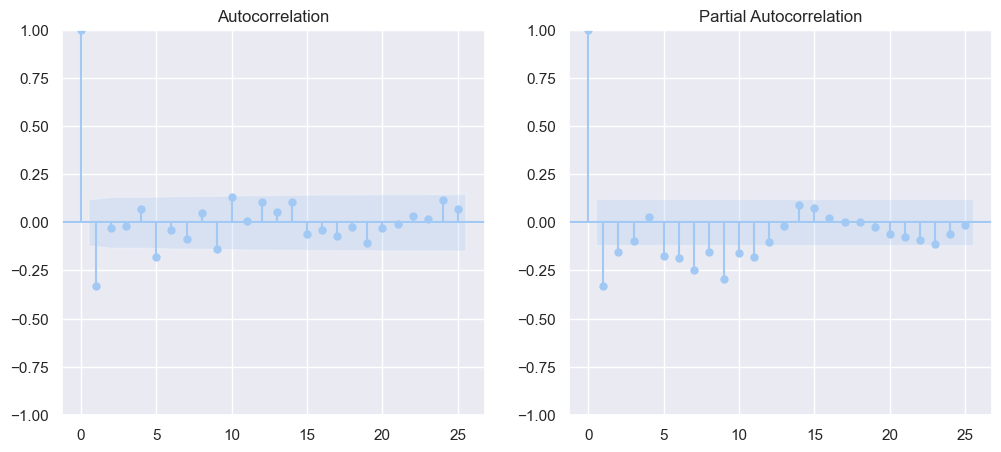

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
plt.show()

It looks like no differencing is required according to the AD Fuller tests performed on the data.

### Preprocessing

We have a number of years of data in our dataset. In order to properly look at the periodicity of the data I will only only include full years in the training, validation and test sets. Since the data starts at the end of 2003, we can remove the end of 2003 and start in 2004.

In [16]:
# Remove incomplete year for train-test split
y = wind_speed_monthly_average['2004':]

We first need to separate our data into three separate groups. A training set, a validation set and a test set. These different groups will be used to train our model and evaluate its effectiveness in predicting future values. First we will take 20% of the entire dataset for a test set, then 20% of the remaining data for a validation set. Normally this is done with a `train_test_split()` method but I wanted to ensure the model takes in complete years.

In [17]:
# Establish 20% test size
test_size = 0.2
number_of_years = y.index.year.max() - y.index.year.min()

# Calculate full training set size
full_training_set_size = round(number_of_years * (1 - test_size))

# Split data into training and test sets
train_full_end_year = y.index.year.min() + full_training_set_size
y_train_full, y_test = y[:f'{train_full_end_year}'], y[f'{train_full_end_year + 1}':]

# Further split training set into training and validation sets
training_set_size = round((y_train_full.index.year.max() - y_train_full.index.year.min())*(1 - test_size))
y_train, y_validation = y_train_full[:f'{y_train_full.index.year.min() + training_set_size}'], y_train_full[f'{y_train_full.index.year.min() + training_set_size + 1}':]
print(f'Training set from {y_train.index.min().date()} to {y_train.index.max().date()}')
print(f'Validation set from {y_validation.index.min().date()} to {y_validation.index.max().date()}')
print(f'Test set from {y_test.index.min().date()} to {y_test.index.max().date()}')

Training set from 2004-01-01 to 2018-12-01
Validation set from 2019-01-01 to 2021-12-01
Test set from 2022-01-01 to 2025-12-01


### Parameter Tuning

In order to get a good picture of which parameters to use for our model, we can run a series of tests.

There are several parameters for this model.

> The p parameter represents the number of lagged observations included in the autoregressive part of the model. For example, if p=2, the model uses the two most recent time steps (t-1 and t-2) to predict the current value (t). This is useful when past values directly influence future values, such as in stock prices where recent trends might persist. The d parameter determines how many times the data is differenced to remove non-stationarity (e.g., trends or changing variance). If d=1, the model uses the difference between consecutive data points (t and t-1). For instance, if monthly sales data has a linear trend, differencing once can stabilize the mean. The q parameter specifies the number of lagged forecast errors in the moving average component. A q=1 model uses the error from the previous prediction to adjust the current forecast, which helps account for sudden shocks or anomalies in the data, like a spike in website traffic due to a viral event.

[Source](https://blog.milvus.io/ai-quick-reference/what-is-an-arima-pdq-model-and-what-do-the-parameters-represent)

The s parameter is the length of the seasonal period. 

The parameters I will be tuning are P and Q, as our investigation told us that no differencing will be required and we already know that monthly data has a seasonal periodicity of 12.

I have several different methods of determining the best model. I can use root mean squared error (RMSE), mean absolute error (MAE), mean squared error (MSE), mean absolute percentage error (MAPE), the alkaike information criterion (AIC) or the bayesian information criterion (BIC). From [this stack exchange question](https://stats.stackexchange.com/questions/219605/determine-best-arima-model-with-aicc-and-rmse) I learned that the first four are a measure of error and disregard the complexity of the model and optimising for these metrics can give you accurate results, but you run the risk of over fitting the model to the data, especially given how much variation there is in the data year to year. AIC metrics take an error term and add a penalty depending how many predictors were used in the model. This punishes overly complex models in favour of simpler, reasonably accurate accurate models. 

For the purpose of model selection I will use AIC to ensure that I am not over fitting the model to the data. To judge how well the model fits the data, later in the investigation I will be using RMSE.

I was getting a ConvergenceWarning, and upon investigation it was suggested to include a max iterations keyword argument in my `model.fit`. [This stack overflow question](https://stackoverflow.com/questions/52872724/convergencewarning-maximum-likelihood-optimization-failed-to-converge) was helpful to correct the error.



In [18]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

# Grid search for best ARIMA parameters

# Define the p, d, q parameters to take any value between 0 and 5
p = range(0, 6)
d = [0]
q = range(0, 4)
s = [12]
pdqs = list(itertools.product(p, d, q, s))


# Initialize variables to store the best results
best_aic = np.inf
best_aic_order = None
best_aic_model = None
history = {}

# Grid search
for order in pdqs:
    try:
        model = ARIMA(
            y_train, seasonal_order=order, trend='ct', freq='MS'
            )
        results = model.fit(method_kwargs={'maxiter':300})
        if results.aic < best_aic:
            best_aic = results.aic
            best_aic_order = order

    except Exception as e:
        print(f'Error for order {order}: {e}')
    finally: 
        history[order] = results.aic
        

print(f'Best ARIMA order: {best_aic_order} with AIC: {best_aic}')

Best ARIMA order: (1, 0, 1, 12) with AIC: 866.9407136022152


Let's have a look at all the scores for the models.

In [19]:
# Convert history dictionary to DataFrame for better visualization

# https://stackoverflow.com/questions/33674033/how-to-convert-a-dictionary-into-a-subscriptable-array
aic_list = list(history.values())

# https://www.geeksforgeeks.org/python/different-ways-to-create-pandas-dataframe/
# Creating DataFrame from dictionary
history_data = { 'p = 0' : [aic_list[0], aic_list[1], aic_list[2], aic_list[3]],
                 'p = 1' : [aic_list[4], aic_list[5], aic_list[6], aic_list[7]],
                 'p = 2' : [aic_list[8], aic_list[9], aic_list[10], aic_list[11]],
                 'p = 3' : [aic_list[12], aic_list[13], aic_list[14], aic_list[15]],
                 'p = 4' : [aic_list[16], aic_list[17], aic_list[18], aic_list[19]],
                 'p = 5' : [aic_list[20], aic_list[21], aic_list[22], aic_list[23]]}

aic_df = pd.DataFrame.from_dict(history_data, orient='index', columns=['q = 0', 'q = 1', 'q = 2', 'q = 3'])

# https://www.geeksforgeeks.org/python/display-the-pandas-dataframe-in-heatmap-style/
# https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html
gmap = np.array([[0, 0, 0, 0,], [0, 1, 0,0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
aic_df.style.background_gradient(cmap ='viridis', gmap=gmap, axis=None)\
        .set_properties(**{'font-size': '20px'})


The AIC values seem to be quite close over the most of grid search but the simplest model while still being effective seems to be with parameters q = 1 and p = 1.

### Fitting the model

Using the parameters established in the parameter tuning, we can now build our model and fit our data.

In [20]:
model = ARIMA(y_train, seasonal_order=(1,0,1,12), trend='ct', freq='MS')
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                     wdsp   No. Observations:                  180
Model:             ARIMA(1, 0, [1], 12)   Log Likelihood                -428.488
Date:                  Tue, 16 Dec 2025   AIC                            866.975
Time:                          22:35:56   BIC                            882.940
Sample:                      01-01-2004   HQIC                           873.448
                           - 12-01-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9893      0.812     17.235      0.000      12.398      15.580
x1             0.0049      0.004      1.206      0.228      -0.003       0.013
ar.S.L12       0.9990      0.024    

c:\Users\luxxx\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We can now visualise our model compared to the data in the validation set.

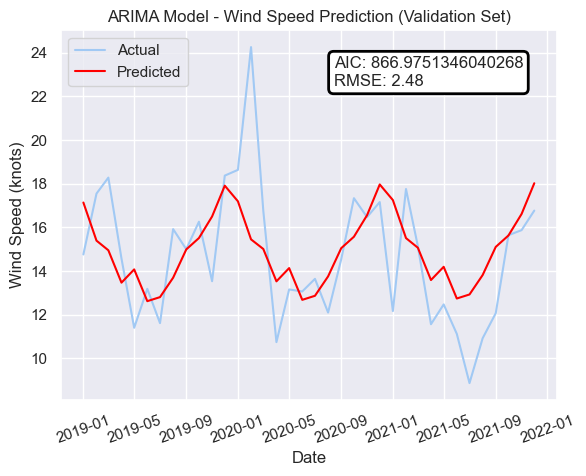

In [21]:
y_hat_validation = model_fit.forecast(steps=len(y_validation))
plt.plot(y_validation.index, y_validation, label='Actual')
plt.plot(y_validation.index, y_hat_validation, label='Predicted', color='red')
plt.title('ARIMA Model - Wind Speed Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.annotate(f'AIC: {model_fit.aic}\nRMSE: {sqrt(mean_squared_error(y_validation, y_hat_validation)):.2f}', xy=(0.55, 0.85), xycoords='axes fraction',
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2))
plt.legend()

The metrics look pretty solid. Let's see how this stands up against the test set.

In order to get the best prediction for the test set, we incorporate the data from the validation set and get an updated prediction using the same model trained on more data.

<div>
<img src="images/2KHMQ.png" width="1000"/>
</div>
Source: https://stats.stackexchange.com/questions/346907/splitting-time-series-data-into-train-test-validation-sets

[This geeks for geeks page](https://www.geeksforgeeks.org/python/how-to-change-index-values-in-pandas/) helped me to set the correct index for the predicted values.

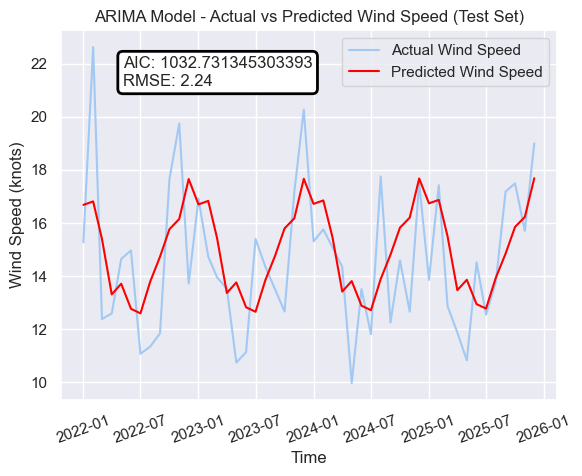

In [22]:
model = ARIMA(y_train_full, seasonal_order=best_aic_order, trend='ct', freq='MS')
model_fit = model.fit()

y_hat_test = pd.DataFrame(
    model_fit.forecast(
        steps=(len(y_test)+len(y_validation))
        )[len(y_validation):]
    ).set_index(y_test.index)
plt.plot(y_test, label='Actual Wind Speed')
plt.plot(y_hat_test, color='red', label='Predicted Wind Speed')
plt.title('ARIMA Model - Actual vs Predicted Wind Speed (Test Set)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.ylabel('Wind Speed (knots)')
plt.annotate(f'AIC: {model_fit.aic}\nRMSE: {sqrt(mean_squared_error(y_test, y_hat_test)):.2f}', xy=(0.125, 0.85), xycoords=('axes fraction'),
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2))
plt.legend()
plt.show()

The model seems to fit the test set very well. It even gives us a better RMSE score than our validation set. It captures the periodicity of the data incredibly well. 

Now we can use the entire dataset to model a prediction for the next two years based on our data.

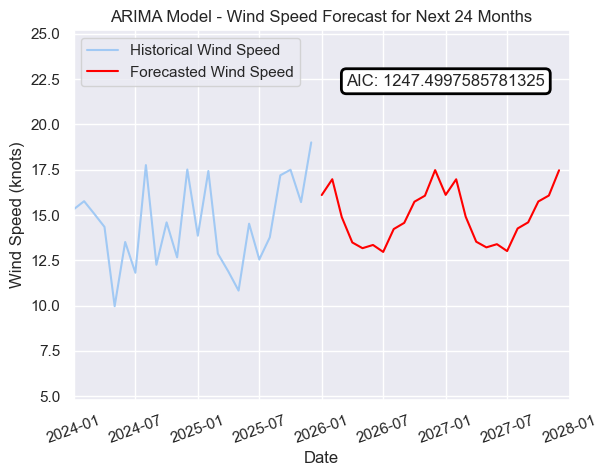

In [23]:
model = ARIMA(y, seasonal_order=best_aic_order, trend='ct', freq='MS')
model_fit = model.fit()

prediction = pd.DataFrame(
                    model_fit.forecast(
                        steps=(len(y_test)+len(y_validation)+24)
                    )[len(y_validation)+len(y_test):]
                ).set_index(
                    pd.date_range(
                        start=y_test.index[-1] + pd.DateOffset(months=1),
                        periods=24, freq='MS'
                    )
                )
plt.plot(y, label='Historical Wind Speed')
plt.plot(prediction, color='red', label='Forecasted Wind Speed')
plt.title('ARIMA Model - Wind Speed Forecast for Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.xlim(dt.datetime(2024, 1, 1), dt.datetime(2028, 1, 1))
plt.legend()
plt.annotate(f'AIC: {model_fit.aic}', xy=(0.55, 0.85), xycoords='axes fraction',
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2))
plt.show()

## Tensor Flow

https://www.tensorflow.org/tutorials/structured_data/time_series

# End

notes:

plot model loss and accuracy
distribution of averages, by month, is it normal mean and variance of each month, year
t test to see if months are the same or different
strip plots seaborn
box plots

https://thelinuxcode.com/seaborn-lineplot/

https://duckduckgo.com/?q=cross+validation+ARIMA&ia=web

https://www.tensorflow.org/tutorials/structured_data/time_series